In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

In [3]:
sns.set_style("whitegrid")

In [4]:
def plot_model_comparison(
    paths: list[str], 
    labels: list[str], 
    title: str, 
    subtitle: str = None, 
    loss_indices: list[int] = None,
    include_train: bool = True,
    include_val: bool = True,
):
    if len(paths) != len(labels):
        raise Exception("Did not provide an equal number of paths and labels!")

    figsize = (12, 6) if include_train + include_val > 1 else (10, 6)
    fig, ax = plt.subplots(nrows=1, ncols=(include_train + include_val), figsize=figsize)
    if loss_indices is None: loss_indices = [0] * len(paths)

    for idx, path in enumerate(paths):
        label = labels[idx]
        checkpoint = torch.load(path, map_location=torch.device("cpu"))

        train_losses = [loss[loss_indices[idx]].item() for loss in checkpoint["train_losses"]]
        train_epochs = np.arange(1, len(train_losses) + 1)

        validation_losses = [loss[loss_indices[idx]].item() for loss in checkpoint["validation_losses"]]
        val_epochs = np.arange(1, len(validation_losses) + 1)

        if (include_train): sns.lineplot(
            x=train_epochs, 
            y=train_losses, 
            label=f"Train {label}", 
            color=f"C{idx}",
            ax=ax[0] if include_val else ax,
        )
        if (include_val): sns.lineplot(
            x=val_epochs, 
            y=validation_losses, 
            label=f"Validation {label}", 
            color=f"C{idx}",
            ax=ax[1] if include_train else ax,
        )

    if include_train + include_val > 1:
        title_axes = ax[0] if include_train + include_val > 1 else ax
        plt.text(x=0.5, y=1.025, s=title, fontsize=16, ha="center", va="bottom", transform=title_axes.transAxes)
    else:
        plt.title(title, pad=24, fontsize=16)

    if subtitle:
        subtitle_axes = ax[1] if include_train + include_val > 1 else ax
        plt.text(x=0.5, y=1.025, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom", transform=subtitle_axes.transAxes)

    plt.xlabel("Training Epoch #")
    plt.ylabel("Mean Epoch Loss")
    plt.legend()
    plt.show()

In [5]:
def plot_scores_comparison(
    scores,
    labels: tuple[str], 
    title: str = None,
    subtitle: str = None,
    bins: int = 20,
):
    fig, ax = plt.subplots()

    for idx, score_list in enumerate(scores):
        mean = np.mean(score_list)
        median = np.median(score_list)
        label = f"{labels[idx]} (mean={mean:.3f}, median={median:.3f})"
        sns.histplot(score_list, ax=ax, label=label, color=f"C{idx}", alpha=0.5, bins=bins)

    ax.set_xlabel("F1 Score")
    ax.set_ylabel("Datapoint Count")
    plt.xlim([-0.03, 1.02])

    if (title):
        pad = 24 if subtitle else None
        ax.set_title(title, pad=pad)
    if (subtitle):
        subtitle_x = 0.5
        subtitle_y = plt.gca().get_ylim()[1] + 3
        plt.text(x=subtitle_x, y=subtitle_y, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom")

    ax.legend()
    plt.show()

In [6]:
import json

def read_dict_from_file(file_path: str):
    with open(file_path) as file:
        return json.load(file)

def read_list_from_file(file_path: str, data_type=float):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            element = data_type(line.strip())
            data.append(element)
    return data

In [7]:
# For some control point experiments, we want to load both the multi_mask="mean"
# and multi_mask="best" variants of the f1 scores.
def read_mm_variants(file_path):
    base_path = file_path.replace(".txt", "")
    return [
        *read_list_from_file(base_path + "_emm=mean.txt"),
        *read_list_from_file(base_path + "_emm=best.txt"),
    ]

# Prompting

## Effect of Prompt Type

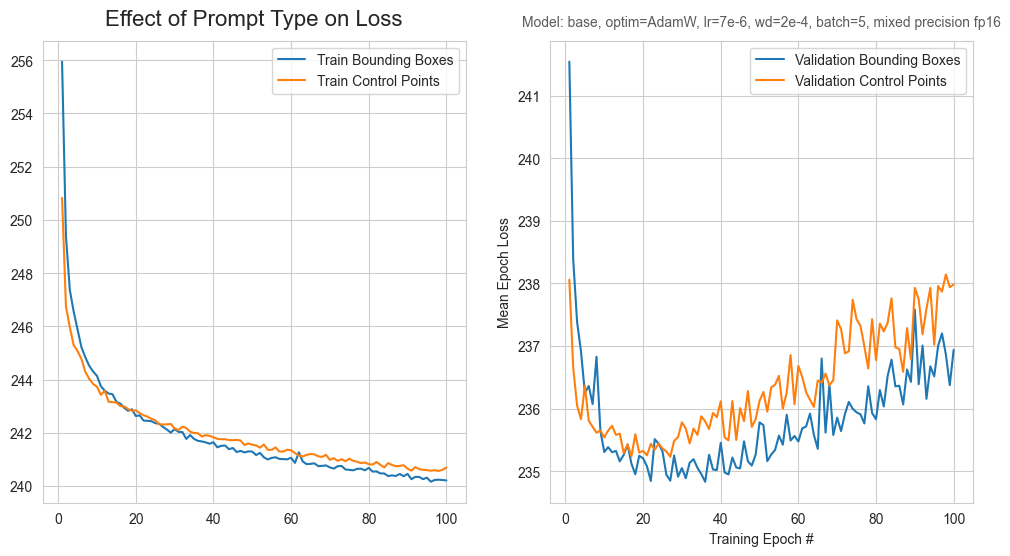

In [7]:
plot_model_comparison(
    [
        "./prompts/last_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_bbox_10_loss=dice.pth",
        "./prompts/last_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice.pth",
    ],
    ["Bounding Boxes", "Control Points"],
    title="Effect of Prompt Type on Loss",
    subtitle="Model: base, optim=AdamW, lr=7e-6, wd=2e-4, batch=5, mixed precision fp16",
)

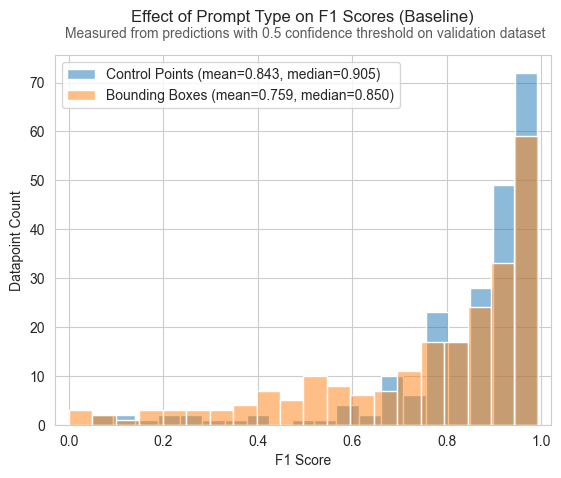

In [8]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_base_pts_3p0n_erode.txt"),
        read_list_from_file("./prompts/f1_scores_original_base_bbox_10.txt"),
    ), 
    ("Control Points", "Bounding Boxes"),
    title="Effect of Prompt Type on F1 Scores (Baseline)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset"
)

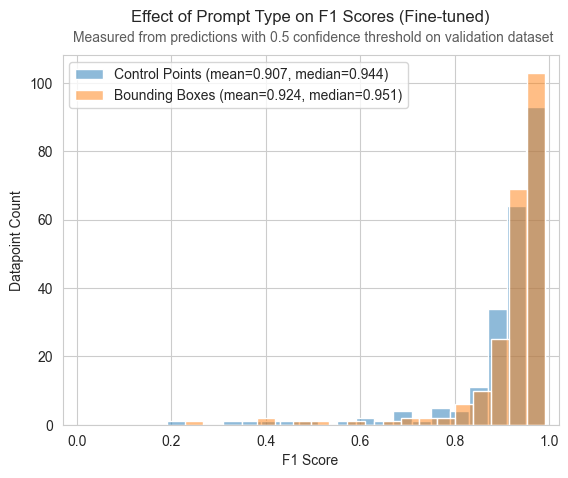

In [9]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_bbox_10_loss=dice.txt"),
    ), 
    ("Control Points", "Bounding Boxes"),
    title="Effect of Prompt Type on F1 Scores (Fine-tuned)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset"
)

## Effect of Fine-tuning

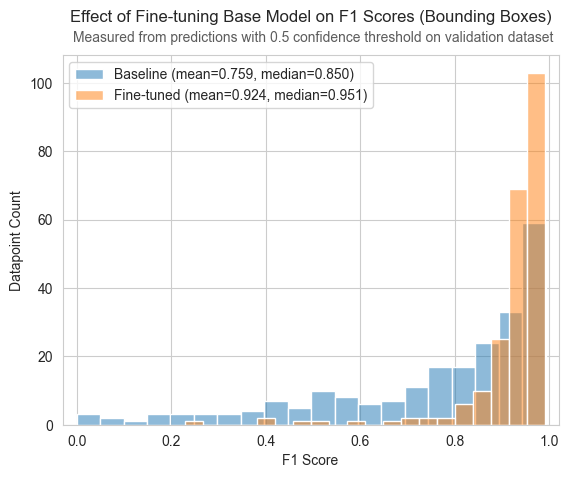

In [10]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_base_bbox_10.txt"),
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_bbox_10_loss=dice.txt"),
    ), 
    ("Baseline", "Fine-tuned"),
    title="Effect of Fine-tuning Base Model on F1 Scores (Bounding Boxes)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

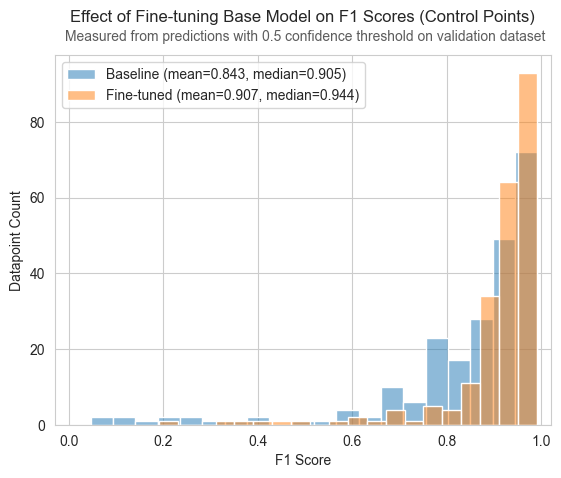

In [11]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_base_pts_3p0n_erode.txt"),
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
    ), 
    ("Baseline", "Fine-tuned"),
    title="Effect of Fine-tuning Base Model on F1 Scores (Control Points)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

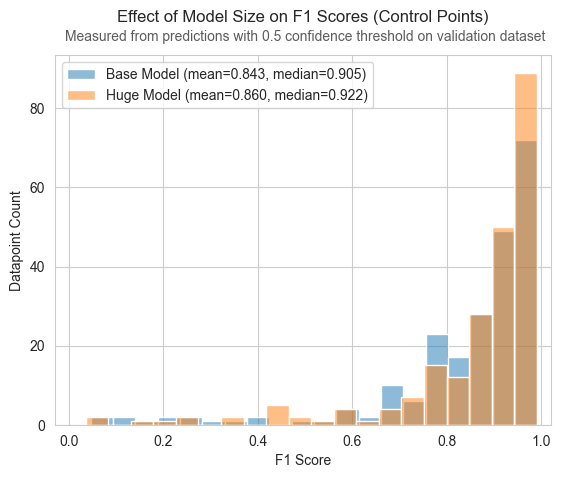

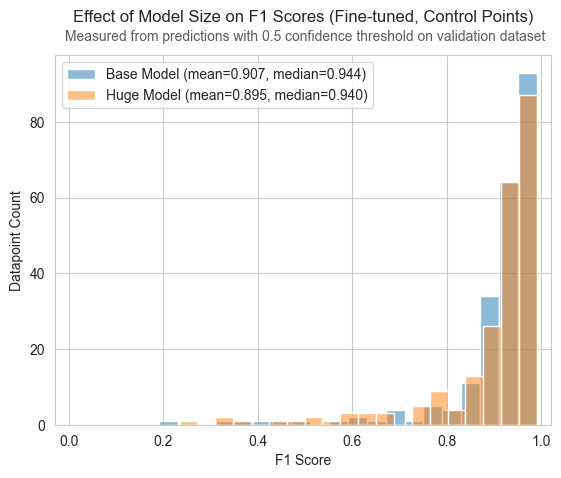

In [12]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_base_pts_3p0n_erode.txt"),
        read_list_from_file("./prompts/f1_scores_original_huge_pts_3p0n_erode.txt"),
    ), 
    ("Base Model", "Huge Model"),
    title="Effect of Model Size on F1 Scores (Control Points)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
        read_list_from_file("./prompts/f1_scores_huge_AdamW_lr=7e-06_wd=0.0002_bs=3_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
    ), 
    ("Base Model", "Huge Model"),
    title="Effect of Model Size on F1 Scores (Fine-tuned, Control Points)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

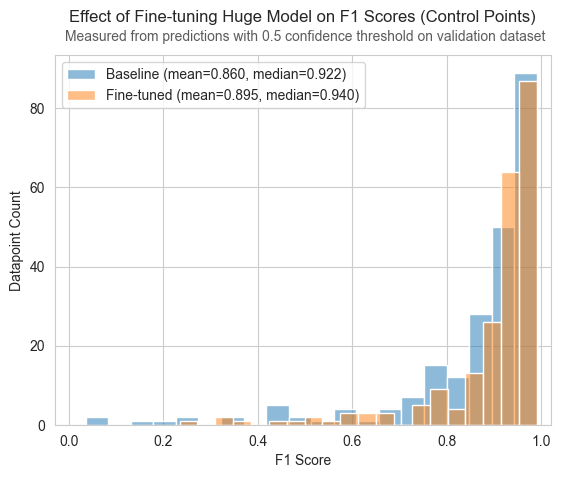

In [13]:
plot_scores_comparison(
    (
        read_list_from_file("./prompts/f1_scores_original_huge_pts_3p0n_erode.txt"),
        read_list_from_file("./prompts/f1_scores_huge_AdamW_lr=7e-06_wd=0.0002_bs=3_mp=fp16_pts_3p0n_erode_loss=dice.txt"),
    ), 
    ("Baseline", "Fine-tuned"),
    title="Effect of Fine-tuning Huge Model on F1 Scores (Control Points)",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

# Hyperparameters

In [14]:
batch_sizes = [size for size in range(1, 8)]
f1_scores = [
    read_list_from_file(f"./hyperparams/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs={size}_mp=fp16_pts_3p0n_erode_loss=dice.txt")
    for size in batch_sizes
]

mean_f1_scores = [np.mean(scores) for scores in f1_scores]
median_f1_scores = [np.median(scores) for scores in f1_scores]

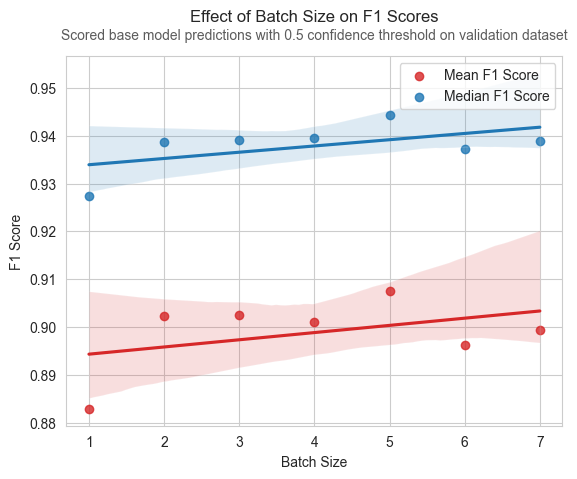

In [15]:
fig, ax = plt.subplots()

sns.regplot(
    x=batch_sizes,
    y=mean_f1_scores, 
    label=f"Mean F1 Score", 
    color="C3",
    # marker="o",
)
sns.regplot(
    x=batch_sizes,
    y=median_f1_scores, 
    label=f"Median F1 Score", 
    color="C0",
    # marker="o",
)

plt.title("Effect of Batch Size on F1 Scores", pad=25)
subtitle_y = plt.gca().get_ylim()[1] * 1.003
plt.text(x=max(batch_sizes)/2+0.5, y=subtitle_y, s="Scored base model predictions with 0.5 confidence threshold on validation dataset", fontsize=10, alpha=0.75, ha="center", va="bottom")

# plt.xticks(batch_sizes)
plt.xlabel("Batch Size")
plt.ylabel("F1 Score")
plt.legend()

plt.show()

# Multi Mask

The f1 score files without mm specified were trained with multi_mask="mean".

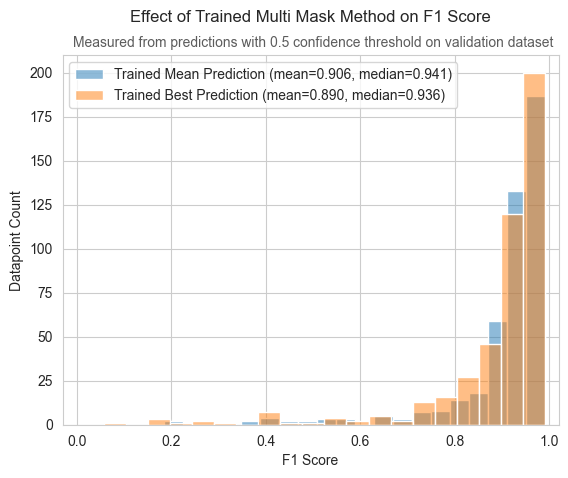

In [25]:
plot_scores_comparison(
    (
        read_mm_variants("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice"),
        read_mm_variants("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=best_erode_loss=dice"),
        
    ),
    ("Trained Mean Prediction", "Trained Best Prediction"),
    title="Effect of Trained Multi Mask Method on F1 Score",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

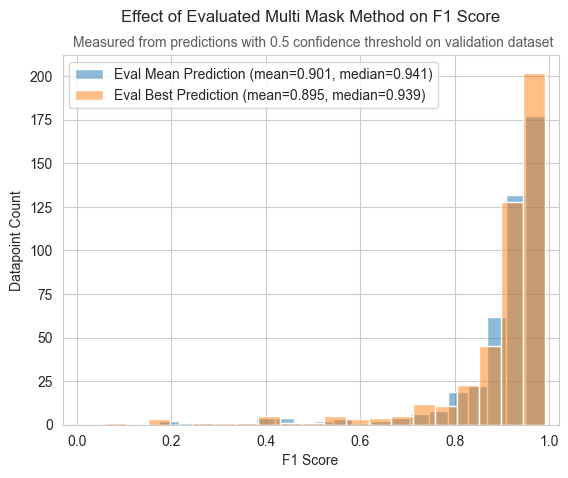

In [125]:
plot_scores_comparison(
    (
        [
            *read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=best_erode_loss=dice_emm=mean.txt"),
            *read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice_emm=mean.txt"),
        ],
        [
            *read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=best_erode_loss=dice_emm=best.txt"),
            *read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice_emm=best.txt"),
        ],
        
    ),
    ("Eval Mean Prediction", "Eval Best Prediction"),
    title="Effect of Evaluated Multi Mask Method on F1 Score",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

In [21]:
train_best_eval_mean = read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=best_erode_loss=dice_emm=mean.txt")
train_best_eval_best = read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=best_erode_loss=dice_emm=best.txt")
train_mean_eval_mean = read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice_emm=mean.txt")
train_mean_eval_best = read_list_from_file("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice_emm=best.txt")

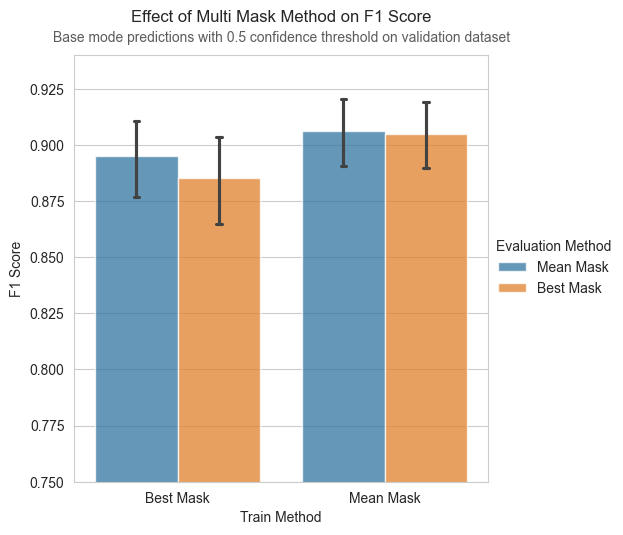

In [33]:
df = pd.DataFrame({
    "F1 Score": itertools.chain(train_best_eval_mean, train_best_eval_best, train_mean_eval_mean, train_mean_eval_best),
    "Train Method": ["Best Mask"] * len(train_best_eval_mean + train_best_eval_best) + ["Mean Mask"] * len(train_mean_eval_mean + train_mean_eval_best),
    "Evaluation Method": ["Mean Mask"] * len(train_best_eval_mean) + ["Best Mask"] * len(train_best_eval_best) + ["Mean Mask"] * len(train_mean_eval_mean) + ["Best Mask"] * len(train_mean_eval_best),
})

g = sns.catplot(
    data=df, kind="bar",
    x="Train Method", y="F1 Score", hue="Evaluation Method",
    errorbar="ci", alpha=.75, capsize=0.05,
)
g.despine(top=False, right=False)
plt.ylim([0.75, 0.94])

title = "Effect of Multi Mask Method on F1 Score"
subtitle = "Base mode predictions with 0.5 confidence threshold on validation dataset"

if (title):
    pad = 24 if subtitle else None
    plt.title(title, pad=pad)
if (subtitle):
    subtitle_x = 0.5
    subtitle_y = plt.gca().get_ylim()[1] * 1.005
    plt.text(x=subtitle_x, y=subtitle_y, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom")

# Loss

In [8]:
losses = ["dice", "19-1", "focal"]
all_metrics = [
    read_dict_from_file(f"./loss/metrics_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=mean_erode_loss={loss}_emm=mean.json") 
    for loss in losses
]

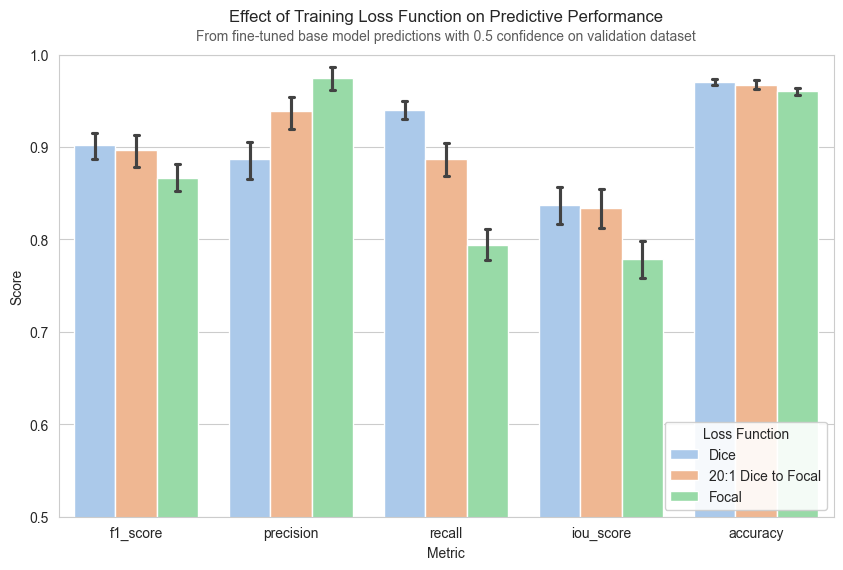

In [40]:
loss_functions = ["Dice", "20:1 Dice to Focal", "Focal"]
data = []

for index, metrics in enumerate(all_metrics):
    for metric, values in metrics.items():
        for value in values:
            data.append({
                "Loss Function": loss_functions[index],
                "Metric": metric,
                "Score": value,
            })

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x="Metric", y="Score", hue="Loss Function", data=df, errorbar="ci", capsize=0.1, palette="pastel")
bar_plot.set_xlabel("Metric")
bar_plot.set_ylabel("Score")
plt.ylim([0.5, 1])

title = "Effect of Training Loss Function on Predictive Performance"
subtitle = "From fine-tuned base model predictions with 0.5 confidence on validation dataset"
if (title):
    pad = 24 if subtitle else None
    plt.title(title, pad=pad)
if (subtitle):
    subtitle_x = 2
    subtitle_y = plt.gca().get_ylim()[1] * 1.0125
    plt.text(x=subtitle_x, y=subtitle_y, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom")

plt.legend(title="Loss Function", loc="lower right", framealpha=0.9)
plt.show()

In [20]:
import itertools

def plot_stats_comparison(
    scores,
    funcs,
    title: str = None,
    subtitle: str = None,
):
    mean_scores = [np.mean(score_list) for score_list in scores]
    median_scores = [np.median(score_list) for score_list in scores]

    df = pd.DataFrame({
        "F1 Score": itertools.chain(mean_scores, median_scores),
        "Type": ["Mean"] * len(mean_scores) + ["Median"] * len(median_scores),
        "Loss Function": funcs + funcs,
    })
    # df = pd.DataFrame({
    #     "F1 Score": itertools.chain(*scores),
    #     "Loss Function": itertools.chain(*[[func] * len(scores[idx]) for idx, func in enumerate(funcs)]),
    # })

    g = sns.catplot(
        data=df, kind="bar",
        x="Loss Function", y="F1 Score", hue="Type",
        errorbar="ci", alpha=.75, capsize=0.05,
    )
    g.despine(right=False)
    plt.ylim([0.85, 1])

    if (title):
        pad = 24 if subtitle else None
        ax.set_title(title, pad=pad)
    if (subtitle):
        subtitle_x = 0.5
        subtitle_y = plt.gca().get_ylim()[1] + 3
        plt.text(x=subtitle_x, y=subtitle_y, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom")

    # ax.legend()
    # plt.show()

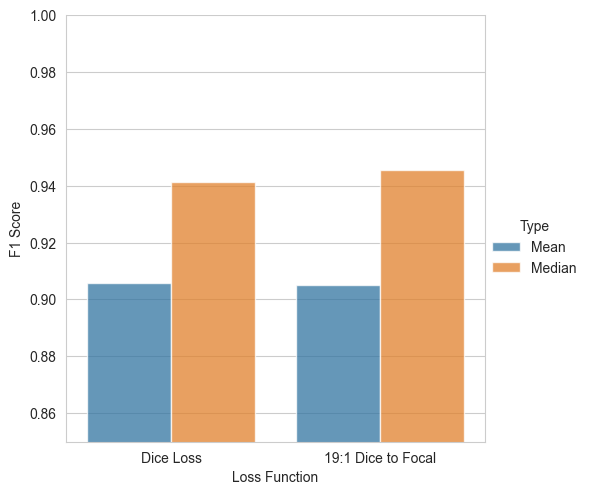

In [122]:
plot_stats_comparison(
    (
        read_mm_variants("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice"),
        read_mm_variants("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=mean_erode_loss=19-1"),
    ),
    ("Dice Loss", "19:1 Dice to Focal"),
)

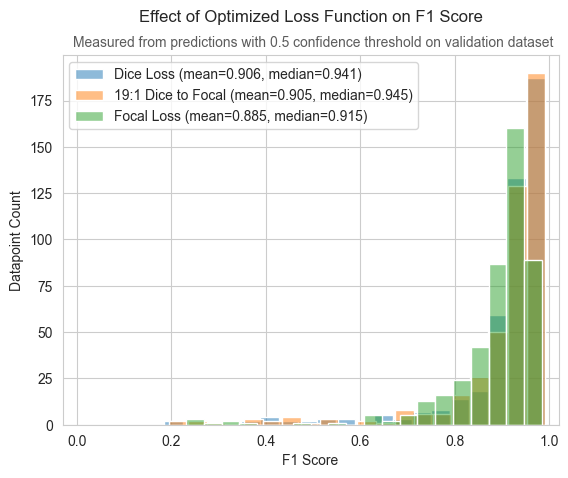

In [146]:
plot_scores_comparison(
    (
        read_mm_variants("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_erode_loss=dice"),
        read_mm_variants("./multimask/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=mean_erode_loss=19-1"),
        read_mm_variants("./loss/f1_scores_base_AdamW_lr=7e-06_wd=0.0002_bs=5_mp=fp16_pts_3p0n_mm=mean_erode_loss=focal"),
    ),
    ("Dice Loss", "19:1 Dice to Focal", "Focal Loss"),
    title="Effect of Optimized Loss Function on F1 Score",
    subtitle="Measured from predictions with 0.5 confidence threshold on validation dataset",
)

In [148]:
average_pixel_count = [10406.305309734513, 11590.238938053097, 13040.566371681416]
trained_loss_function = ["Focal Loss", "19:1 Dice to Focal", "Dice Loss"]

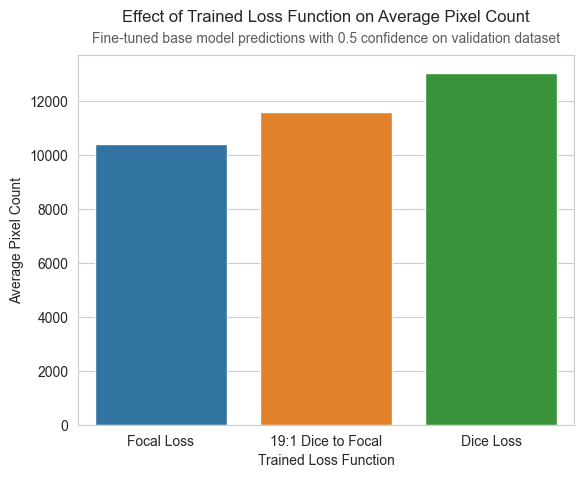

In [161]:
data = {"Trained Loss Function": trained_loss_function, "Average Pixel Count": average_pixel_count}
df = pd.DataFrame(data)

# plt.figure(figsize=(10, 6))
sns.barplot(x="Trained Loss Function", y="Average Pixel Count", hue="Trained Loss Function", data=df)

title = "Effect of Trained Loss Function on Average Pixel Count"
subtitle = "Fine-tuned base model predictions with 0.5 confidence on validation dataset"
if (title):
    pad = 24 if subtitle else None
    plt.title(title, pad=pad)
if (subtitle):
    subtitle_x = 1
    subtitle_y = plt.gca().get_ylim()[1] * 1.025
    plt.text(x=subtitle_x, y=subtitle_y, s=subtitle, fontsize=10, alpha=0.75, ha="center", va="bottom")